In [1]:
setwd('/import/liujing/data2/scrna/')

In [9]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

Loading required package: edgeR

Warning message:
"package 'edgeR' was built under R version 4.2.3"
Loading required package: limma

Warning message:
"package 'limma' was built under R version 4.2.3"
Warning message:
"package 'SingleCellExperiment' was built under R version 4.2.2"
Loading required package: SummarizedExperiment

Warning message:
"package 'SummarizedExperiment' was built under R version 4.2.2"
Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.2.3"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
   

In [2]:
scedata = readRDS('./scRNA.xifen.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [5]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



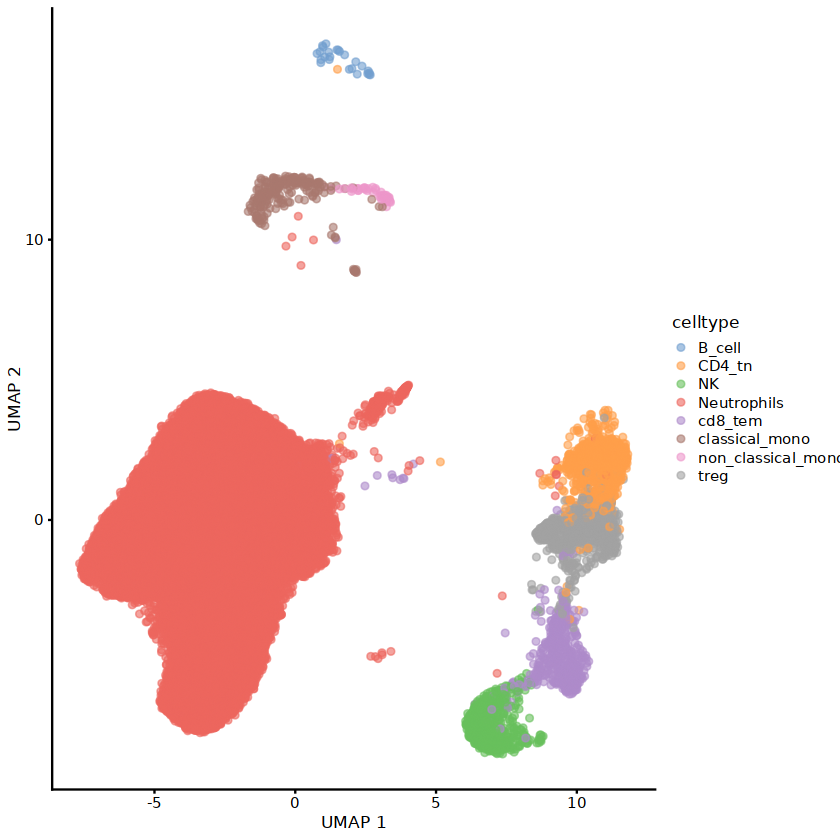

In [10]:
sce <- as.SingleCellExperiment(scedata)
 
#Visualize the data
plotReducedDim(sce, colour_by="celltype", dimred = "UMAP") 

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods

  [[ suppressing 14 column names 'CTR-1.matrix', 'CTR-2.matrix', 'CTR-3.matrix' ... ]]



6 x 14 sparse Matrix of class "dgCMatrix"
                                      
1  2 4  1  3 9 20  .  2 . 11  3  2 . .
2 11 3  .  3 .  .  5  2 . 30 22  4 1 .
3  . .  . 46 2  .  2  1 .  2  1  4 . .
4  1 . 14 13 5  2  2  . 2  .  6 12 1 .
5 10 3  1  8 6 26  2 13 . 17 10  1 . 8
6 30 1  3  6 .  . 23 10 1 26 22  1 4 2

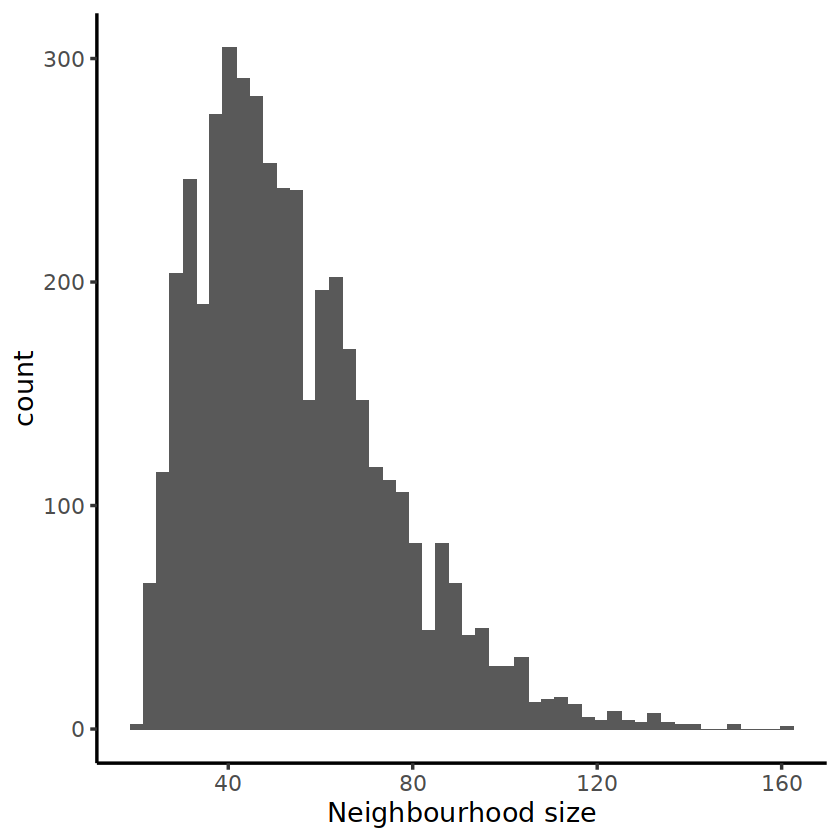

In [11]:
scmilo <- Milo(sce)
 
#Construct KNN graph
scmilo <- buildGraph(scmilo, k = 20, d = 20,reduced.dim = "PCA")
 
#Defining representative neighbourhoods on the KNN graph
set.seed(10)
scmilo <- makeNhoods(scmilo, prop = 0.1,
                     k = 20, d = 20, 
                     refined = TRUE, reduced_dims = "PCA")
plotNhoodSizeHist(scmilo)
 
#Counting cells in neighbourhoods
scmilo <- countCells(scmilo, 
                     meta.data = as.data.frame(colData(scmilo)), 
                     sample = "orig.ident")
head(nhoodCounts(scmilo))

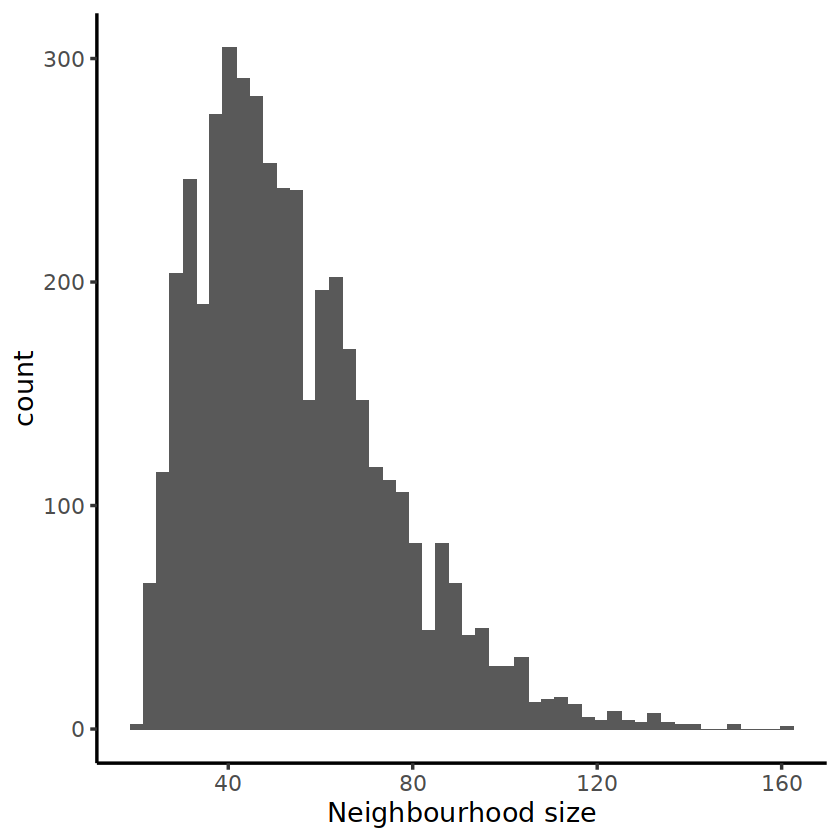

In [13]:
plotNhoodSizeHist(scmilo)

In [32]:
sc_design <- data.frame(colData(scmilo))[,c("orig.ident", "group")]

In [33]:
sc_design <- distinct(sc_design)
rownames(sc_design) <- sc_design$orig.ident

In [34]:
sc_design <- sc_design[colnames(nhoodCounts(scmilo)), , drop=FALSE]
table(sc_design$group)


 CI Con 
  8   6 

In [35]:

#odDistance(scmilo, d = 20, reduced.dim = "PCA")

In [36]:
rownames(sc_design) <- sc_design$orig.ident

In [37]:
sc_design$Con = c(rep(1,6),rep(0,8))
sc_design$CI = c(rep(0,6),rep(1,8))

In [38]:
sc_design$Con  = as.factor(sc_design$Con )

In [39]:
sc_design$CI = as.factor(sc_design$CI )

In [40]:
model <- model.matrix(~ 0+group, data=sc_design)

In [41]:
model

,groupCI,groupCon
CTR-1.matrix,0,1
CTR-2.matrix,0,1
CTR-3.matrix,0,1
CTR-4.matrix,0,1
CTR-5.matrix,0,1
CTR-6.matrix,0,1
QG-1.matrix,1,0
QG-2.matrix,1,0
QG-3.matrix,1,0
QG-4.matrix,1,0


In [42]:
contrast.1 <- c("groupCI -  groupCon") # the syntax is <VariableName><ConditionLevel> - <VariableName><ControlLevel>

In [43]:
# we need to use the ~ 0 + Variable expression here so that we have all of the levels of our variable as separate columns in our model matrix
results <- testNhoods(scmilo, design = ~0 + group, design.df = sc_design, model.contrasts = contrast.1,
                         fdr.weighting="graph-overlap", norm.method="TMM")
table(results$SpatialFDR < 0.1)

Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting




FALSE  TRUE 
 3979   470 

In [44]:
results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,5.656451,8.400152,12.10618,0.0005029512,0.01775897,18,0.01756476
22,5.383483,8.228835,11.61625,0.0006542642,0.01805920,22,0.01756476
29,6.707008,9.161492,14.61598,0.0001319416,0.01770128,29,0.01756476
38,6.322312,8.866118,13.51891,0.0002364024,0.01770128,38,0.01756476
52,5.804880,8.497553,12.42660,0.0004236170,0.01770128,52,0.01756476
80,5.948224,8.596245,12.66109,0.0003736684,0.01770128,80,0.01756476


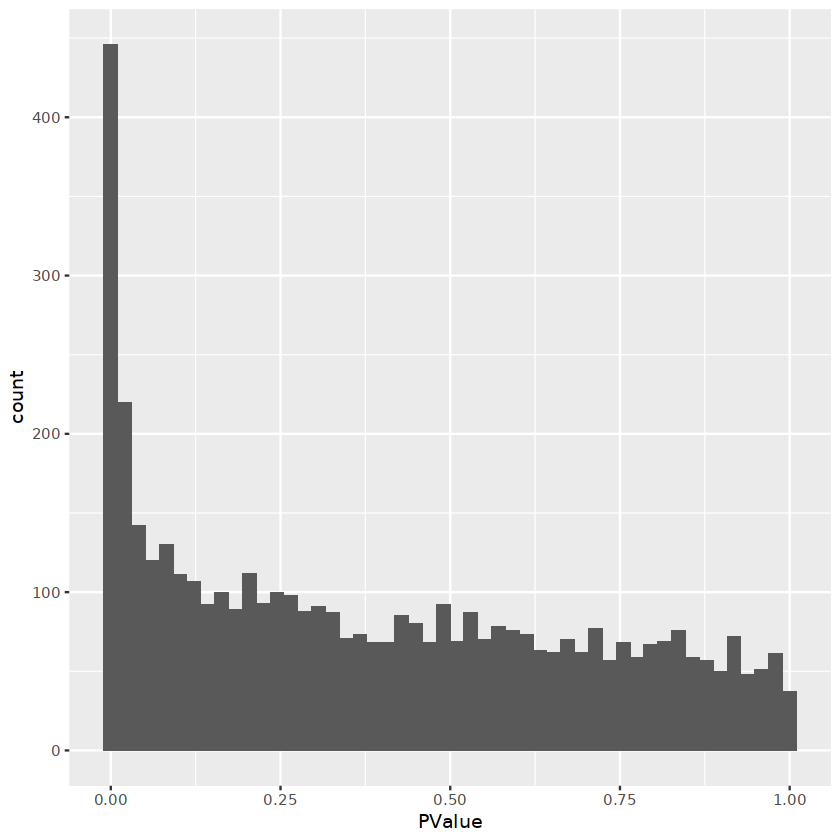

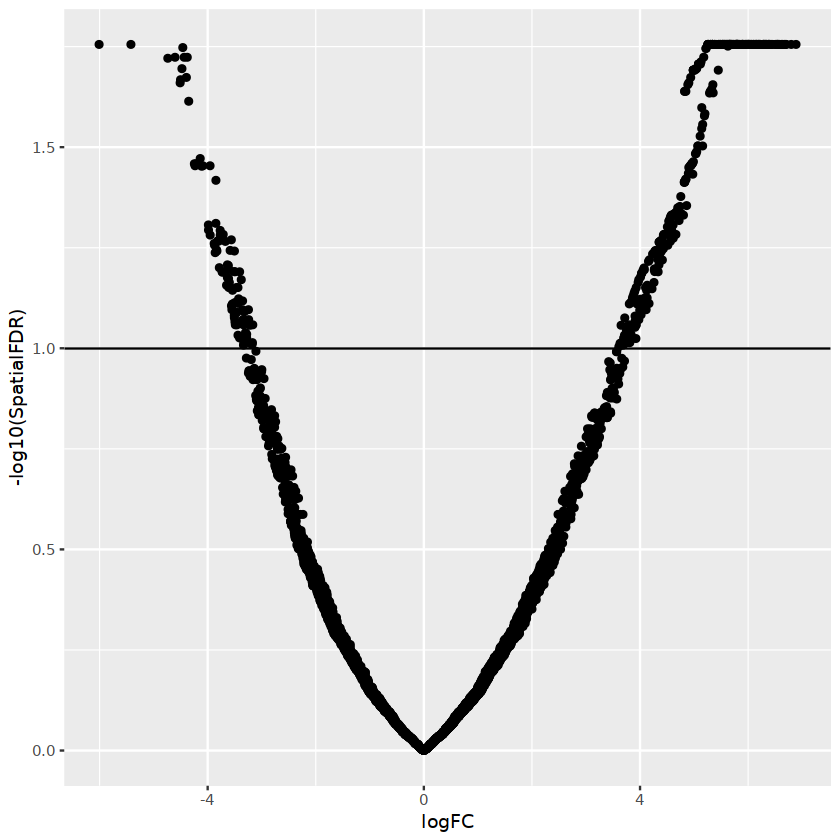

In [45]:
ggplot(results, aes(PValue)) + geom_histogram(bins=50)
ggplot(results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) 

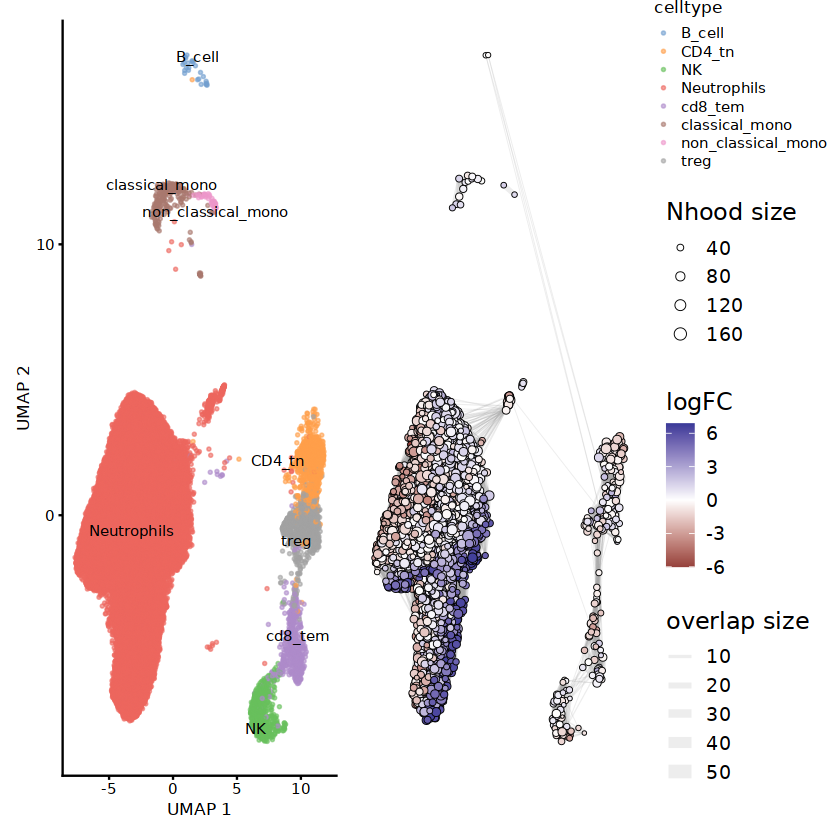

In [46]:
scmilo <- buildNhoodGraph(scmilo)
 
## Plot single-cell UMAP
umap_pl <- plotReducedDim(scmilo, dimred = "UMAP", 
                          colour_by="celltype", text_by = "celltype", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")
 
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(scmilo, results, layout="UMAP",alpha = 1) 
 
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [47]:
results <- annotateNhoods(scmilo, results, coldata_col = "celltype")

Converting celltype to factor...



In [48]:
table(results$celltype)


            B_cell             CD4_tn                 NK        Neutrophils 
                 2                 70                 56               4204 
           cd8_tem     classical_mono non_classical_mono               treg 
                42                 13                  2                 60 

In [251]:
# https://rdrr.io/github/MarioniLab/miloR/f/vignettes/milo_contrasts.Rmd

Converting group.by to factor...



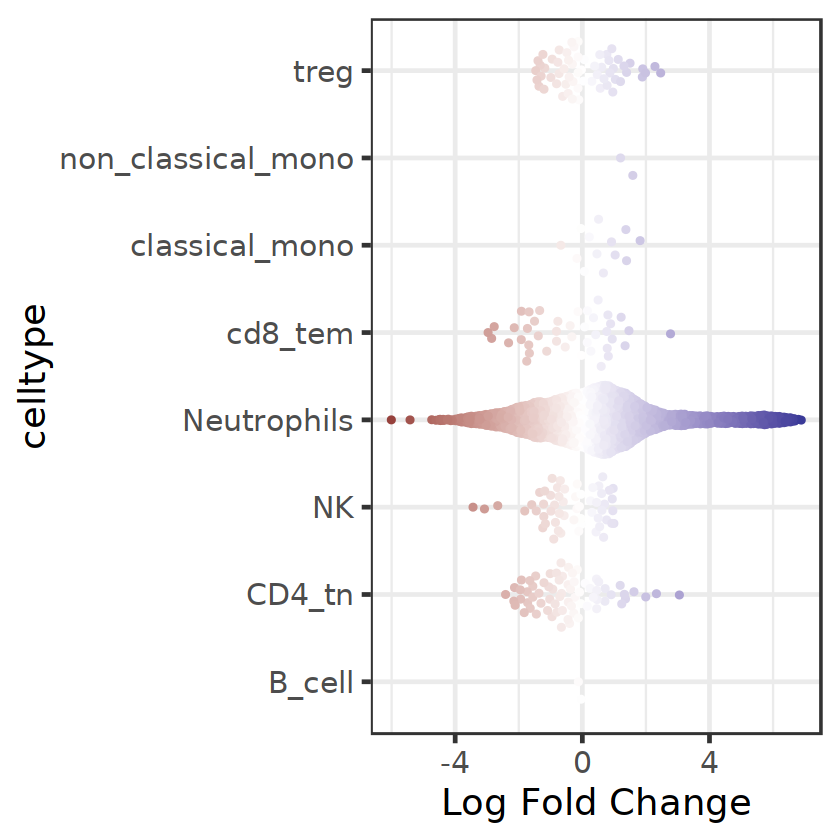

In [49]:
plotDAbeeswarm(results, group.by = "celltype",alpha = 1)

In [50]:
DefaultAssay(scRNA) ='RNA'

ERROR: Error in DefaultAssay(scRNA) = "RNA": object 'scRNA' not found


In [ ]:
Idents(scRNA) = 'celltype'

In [ ]:
FeaturePlot(scRNA,features = 'NFATC1')